In [140]:
#Dependencies
import yfinance as yf
import json, requests
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import sklearn as skl
import pandas as pd
import numpy as np
import tensorflow as tf
import datetime
import re
import time,ciso8601
import scipy.stats as st
import matplotlib.pyplot as plt
from scipy import stats

In [6]:
nasdaq_df = pd.read_csv("nasdaq500.csv")
nasdaq_df

,Symbol,Name,Sector
0,MMM,3M Co.,Industrials
1,ACE,ACE Limited,Financials
2,ABT,Abbott Laboratories,Health Care
3,ANF,Abercrombie & Fitch Company A,Consumer Discretionary
4,ACN,Accenture,Information Technology
...,...,...,...
495,XYL,Xylem Inc.,Industrials
496,YHOO,Yahoo Inc.,Information Technology
497,YUM,Yum! Brands Inc,Consumer Discretionary
498,ZMH,Zimmer Holdings,Health Care


# Getting stock data info using yfinance API

In [7]:
stock = yf.Ticker("TSLA")
stock

yfinance.Ticker object <TSLA>

In [8]:
stock_df= stock.history(interval="1d", start="2019-01-01", end="2022-01-01").reset_index()

In [9]:
def to_timestamp(date):
    return int(datetime.datetime.strptime(str(date.date()), "%Y-%m-%d").timestamp())

In [11]:
#Converting the dates to timestamps to make it much easier to graph
stock_timestamps=[]
for dates in stock_df["Date"]:
    stock_timestamps.append(to_timestamp(dates))
stock_df["timestamps"]=stock_timestamps
stock_df

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,timestamps
0,2019-01-02 00:00:00-05:00,20.406668,21.008667,19.920000,20.674667,174879000,0.0,0.0,1546416000
1,2019-01-03 00:00:00-05:00,20.466667,20.626667,19.825333,20.024000,104478000,0.0,0.0,1546502400
2,2019-01-04 00:00:00-05:00,20.400000,21.200001,20.181999,21.179333,110911500,0.0,0.0,1546588800
3,2019-01-07 00:00:00-05:00,21.448000,22.449333,21.183332,22.330667,113268000,0.0,0.0,1546848000
4,2019-01-08 00:00:00-05:00,22.797333,22.934000,21.801332,22.356667,105127500,0.0,0.0,1546934400
...,...,...,...,...,...,...,...,...,...
752,2021-12-27 00:00:00-05:00,357.890015,372.333344,356.906677,364.646667,71145900,0.0,0.0,1640592000
753,2021-12-28 00:00:00-05:00,369.829987,373.000000,359.473328,362.823334,60324000,0.0,0.0,1640678400
754,2021-12-29 00:00:00-05:00,366.213318,368.000000,354.713318,362.063324,56154000,0.0,0.0,1640764800
755,2021-12-30 00:00:00-05:00,353.776672,365.183319,351.049988,356.779999,47040900,0.0,0.0,1640851200


# My Pre-ML attempt at building a trading bot

In [13]:
#creating bollinger bands based on given intervals
def bandz(df, interval):
    mean=0
    std_dev=0
    buytime=[]
    selltime=[]
    buyprice=[]
    sellprice=[]
    bands=[]
    slope=0
    slopes=[]
    buy=[]
    sell=[]
    for i in range(len(df)-interval):
        mean=df["Close"][i:i+interval].mean()
        std_dev=df["Close"][i:i+interval].std()
        upper=mean+(1.25*std_dev)
        lower=mean-(1.5*std_dev)
        slope= (df["Close"][i+interval]-df["Close"][i+interval-2])/2
        slopes.append(slope)
       
        if len(slopes) > 2:
            ismin = bool((slopes[i] < 0) & (slopes[i-2] > 0))
            ismax = bool((slopes[i] > 0) & (slopes[i-2] < 0))
            if(ismin==True and df["Close"][i+interval]<=lower):
                buy.append([df["Close"][i+interval],df["timestamps"][i+interval]])
            if(ismax==True and df["Close"][i+interval]>=upper and len(buy)>len(sell)):
                sell.append([df["Close"][i+interval],df["timestamps"][i+interval]])
        bands.append([lower, mean, upper, df["timestamps"][i+interval]])
    return [pd.DataFrame(bands, columns=["lower", "mean", "upper", "timestamps"]), 
            pd.DataFrame(buy, columns=["Close", "timestamps"]), pd.DataFrame(sell, columns=["Close", "timestamps"])]

In [14]:
buy_df=bandz(stock_df, 5)[1]

In [15]:
buy_df

,Close,timestamps
0,20.150667,1547798400
1,19.927999,1548144000
2,20.386667,1549612800
3,20.251333,1550131200
4,19.415333,1550736000
5,19.024000,1551686400
6,17.966000,1552892400
7,17.635332,1553238000
8,17.361334,1553497200
9,17.851999,1554361200


In [16]:
sell_df=bandz(stock_df, 5)[2]

In [17]:
sell_df

,Close,timestamps
0,17.002001,1556866800
1,12.906667,1559631600
2,13.106000,1559718000
3,15.002000,1560754800
4,15.928000,1562742000
5,15.906667,1562828400
6,15.886667,1565247600
7,16.440001,1568876400
8,19.978666,1571900400
9,22.635332,1575878400


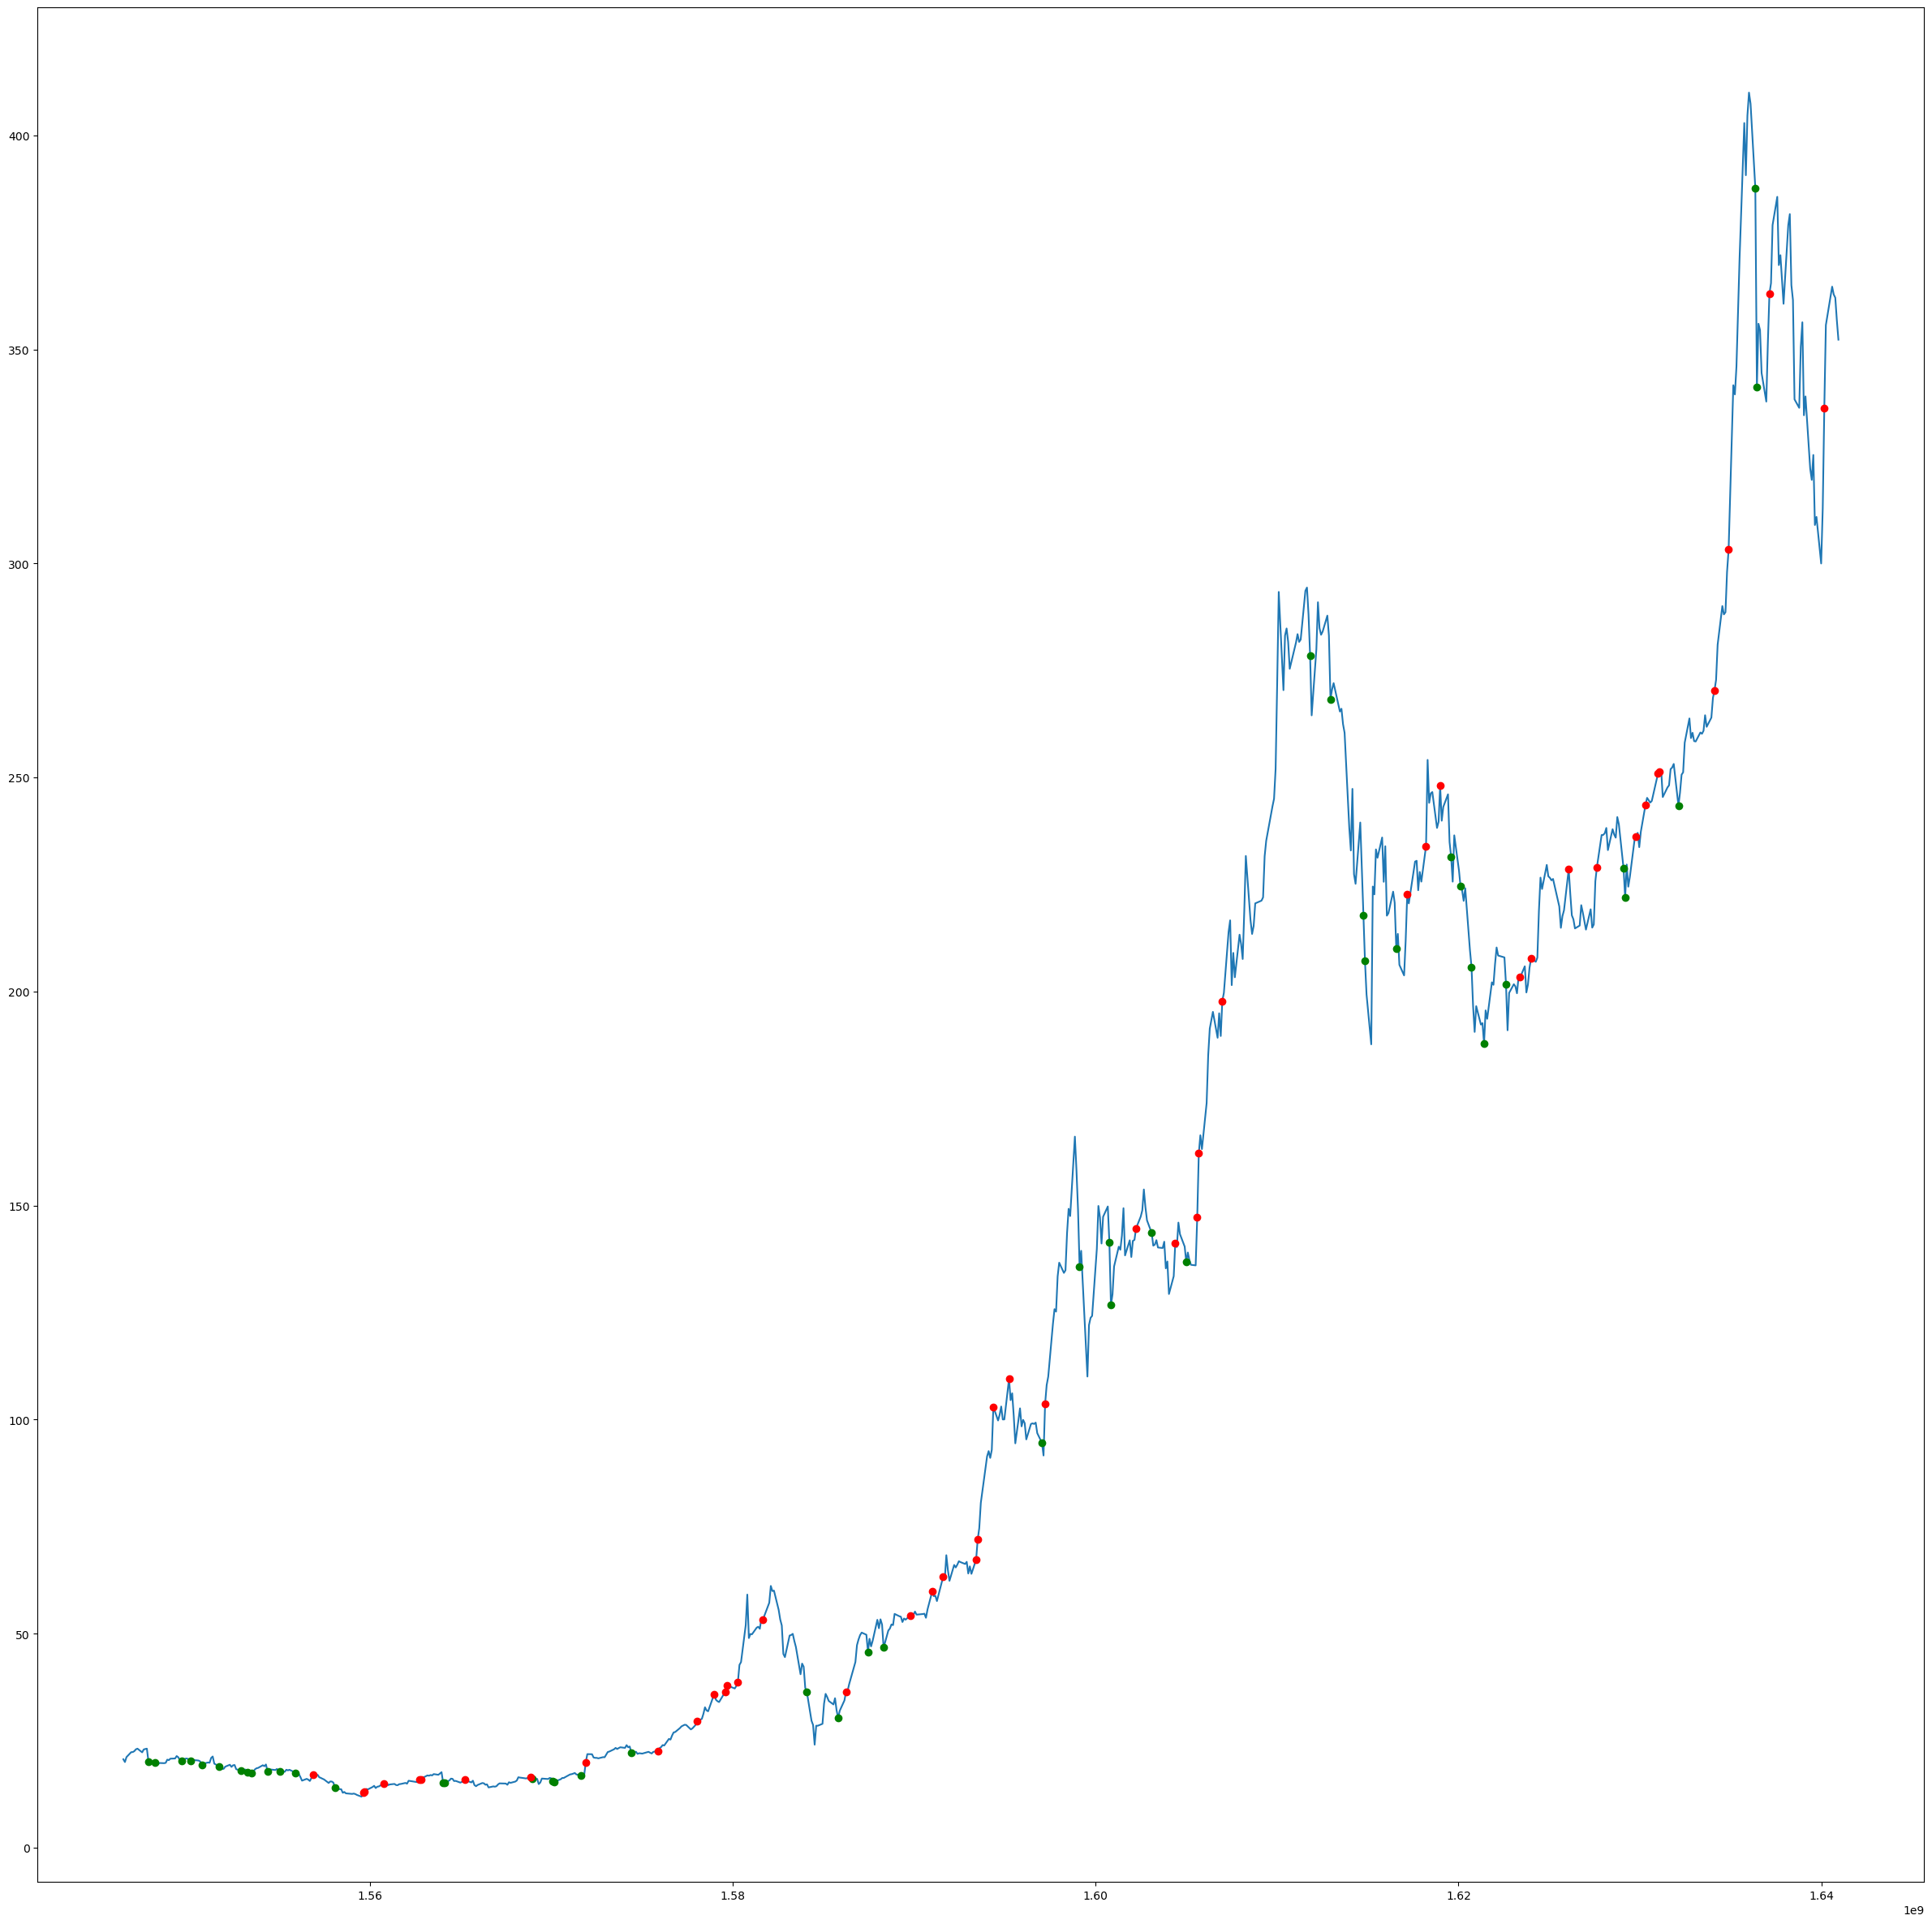

In [18]:
plt.figure(figsize=(30, 30))
plt.plot(stock_df["timestamps"], stock_df["Close"])
plt.plot(buy_df['timestamps'], buy_df["Close"], 'o', color="g")
plt.plot(sell_df['timestamps'], sell_df["Close"], 'o', color="r")
plt.show()


# Post-ML code

In [19]:
def horizontal_stock_df1():
    tickers = nasdaq_df["Symbol"]
    dataframe=pd.DataFrame({})
    for ticker in tickers:
        try:
            stonk = yf.Ticker(ticker)
            stonk_df= stonk.history(interval="1d", start="2012-01-01", end="2022-01-01").reset_index()
            dict_={"Ticker":ticker}
            dates = stonk_df["Date"]
            price=stonk_df["Close"]
            for i in range(len(dates)):
                dict_[to_timestamp(dates[i])]=price[i]
            final_stock_df = stock.history(interval="1d", start="2023-01-03", end="2023-01-04").reset_index()

            if price[len(price)-1]>final_stock_df['Close'][0]:
                dict_["Final_Outcome"]=1
            else:
                dict_["Final_Outcome"]=0
            dataframe=pd.concat([dataframe,pd.DataFrame([dict_])])
        except:
            pass
    return dataframe

def horizontal_stock_df3(ticker, start, end):
    stock = yf.Ticker(ticker)
    stocks= stock.history(interval="1d", start=start, end=end).reset_index()
    dict_={"Ticker": ticker}
    dates = stocks["Date"]
    close = stocks["Close"]
    for i in range(len(dates)):
        dict_[to_timestamp(dates[i])] = close[i]
    return pd.DataFrame([dict_])

def horizontal_stock_df2(tickers):
    dataframe=pd.DataFrame({})
    dict_={}
    for ticker in tickers:
        try:
            stonk = yf.Ticker(ticker)
            stonk_df= stonk.history(interval="1d", start="2012-01-01", end="2022-01-01").reset_index()
            dates = stonk_df["Date"]
            price=stonk_df["Close"]
            for i in range(len(dates)):
                dict_[(dates[i])]=price[i]
            final_stock_df = stock.history(interval="1d", start="2023-01-03", end="2023-01-04").reset_index()

            if price[len(price)-1]>final_stock_df['Close'][0]:
                dict_["Final_Outcome"]=1
            else:
                dict_["Final_Outcome"]=0
            dataframe=pd.concat([dataframe,pd.DataFrame([dict_])])
        except:
            pass
    return dataframe.dropna()
    

In [20]:
stocks_df = horizontal_stock_df1()

ARG: No data found for this date range, symbol may be delisted
Got error from yahoo api for ticker ALXN, Error: {'code': 'Not Found', 'description': 'No data found, symbol may be delisted'}
- ALXN: No timezone found, symbol may be delisted
Got error from yahoo api for ticker AGN, Error: {'code': 'Not Found', 'description': 'No data found, symbol may be delisted'}
- AGN: No timezone found, symbol may be delisted
Got error from yahoo api for ticker ABC, Error: {'code': 'Not Found', 'description': 'No data found, symbol may be delisted'}
- ABC: No timezone found, symbol may be delisted
Got error from yahoo api for ticker APC, Error: {'code': 'Not Found', 'description': 'No data found, symbol may be delisted'}
- APC: No timezone found, symbol may be delisted
APOL: No data found for this date range, symbol may be delisted
Got error from yahoo api for ticker AVP, Error: {'code': 'Not Found', 'description': 'No data found, symbol may be delisted'}
- AVP: No timezone found, symbol may be delis

Got error from yahoo api for ticker PKI, Error: {'code': 'Not Found', 'description': 'No data found, symbol may be delisted'}
- PKI: No timezone found, symbol may be delisted
PCLN: No data found for this date range, symbol may be delisted
Got error from yahoo api for ticker QEP, Error: {'code': 'Not Found', 'description': 'No data found, symbol may be delisted'}
- QEP: No timezone found, symbol may be delisted
Got error from yahoo api for ticker RTN, Error: {'code': 'Not Found', 'description': 'No data found, symbol may be delisted'}
- RTN: No timezone found, symbol may be delisted
Got error from yahoo api for ticker RHT, Error: {'code': 'Not Found', 'description': 'No data found, symbol may be delisted'}
- RHT: No timezone found, symbol may be delisted
RAI: No data found for this date range, symbol may be delisted
Got error from yahoo api for ticker RDC, Error: {'code': 'Not Found', 'description': 'No data found, symbol may be delisted'}
- RDC: No timezone found, symbol may be deliste

In [21]:
X= stocks_df.drop(columns=["Ticker", "Final_Outcome"])

In [22]:
X

,1325577600,1325664000,1325750400,1325836800,1326096000,1326182400,1326268800,1326355200,1326441600,1326787200,...,1639728000,1639987200,1640073600,1640160000,1640246400,1640592000,1640678400,1640764800,1640851200,1640937600
0,58.238327,58.719692,58.454590,58.154678,58.503418,58.803364,58.433655,58.789433,58.315094,58.754559,...,160.572510,158.633713,158.890991,158.633713,160.774673,162.364304,163.228058,163.935593,163.228058,163.218857
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,21.378803,21.295877,21.246880,21.054647,21.050886,21.148886,21.069044,20.970200,21.072847,21.179293,...,132.202515,130.148743,130.428391,134.015244,134.179138,136.396835,135.442245,136.136475,135.953293,135.702576
0,36.535446,35.317341,34.293556,33.561195,34.099262,33.598564,33.822754,33.434162,33.620979,34.121674,...,33.549999,32.810001,33.970001,34.200001,34.360001,34.709999,34.330002,35.340000,35.459999,34.830002
0,42.457512,42.441483,41.631611,41.559456,41.487286,42.200924,43.034828,43.251335,42.698067,42.890507,...,384.793549,374.635712,381.540344,392.028351,391.659332,403.332062,403.273743,403.419525,401.875397,402.574615
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,18.616667,18.494097,18.575809,18.521336,18.534950,18.684755,18.446432,18.174065,18.214918,18.180870,...,63.124619,63.237686,62.932224,63.302193,63.188351,63.387566,64.146484,64.469002,64.725136,64.222374
0,14.100863,14.014881,13.928902,13.928902,13.911703,13.946099,14.083665,13.980493,13.894511,13.894511,...,18.113922,17.804811,18.873455,19.332706,19.827286,20.065742,20.348360,20.622143,20.372179,20.211485
0,21.437225,22.144974,21.829473,21.462805,21.548082,21.812424,22.221733,21.914749,21.855064,21.855064,...,113.224350,111.503647,113.390564,113.566536,114.876633,115.648979,116.851509,116.695084,116.440887,117.242584
0,33.654587,33.884438,34.143002,34.390087,34.257931,34.470528,35.172005,35.137371,35.350986,35.732018,...,127.652351,127.304047,129.045654,130.264786,130.951752,133.535217,133.506180,134.164154,133.902893,134.357666


In [23]:
X=stocks_df.dropna()

In [25]:
X

,1325577600,1325664000,1325750400,1325836800,1326096000,1326182400,1326268800,1326355200,1326441600,1326787200,...,1639728000,1639987200,1640073600,1640160000,1640246400,1640592000,1640678400,1640764800,1640851200,1640937600
0,58.238327,58.719692,58.454590,58.154678,58.503418,58.803364,58.433655,58.789433,58.315094,58.754559,...,160.572510,158.633713,158.890991,158.633713,160.774673,162.364304,163.228058,163.935593,163.228058,163.218857
0,21.378803,21.295877,21.246880,21.054647,21.050886,21.148886,21.069044,20.970200,21.072847,21.179293,...,132.202515,130.148743,130.428391,134.015244,134.179138,136.396835,135.442245,136.136475,135.953293,135.702576
0,36.535446,35.317341,34.293556,33.561195,34.099262,33.598564,33.822754,33.434162,33.620979,34.121674,...,33.549999,32.810001,33.970001,34.200001,34.360001,34.709999,34.330002,35.340000,35.459999,34.830002
0,42.457512,42.441483,41.631611,41.559456,41.487286,42.200924,43.034828,43.251335,42.698067,42.890507,...,384.793549,374.635712,381.540344,392.028351,391.659332,403.332062,403.273743,403.419525,401.875397,402.574615
0,28.570000,28.280001,28.480000,28.719999,28.530001,29.200001,29.320000,29.230000,28.969999,29.350000,...,556.640015,549.770020,557.520020,563.979980,569.619995,577.679993,569.359985,569.289978,570.530029,567.059998
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,18.616667,18.494097,18.575809,18.521336,18.534950,18.684755,18.446432,18.174065,18.214918,18.180870,...,63.124619,63.237686,62.932224,63.302193,63.188351,63.387566,64.146484,64.469002,64.725136,64.222374
0,14.100863,14.014881,13.928902,13.928902,13.911703,13.946099,14.083665,13.980493,13.894511,13.894511,...,18.113922,17.804811,18.873455,19.332706,19.827286,20.065742,20.348360,20.622143,20.372179,20.211485
0,21.437225,22.144974,21.829473,21.462805,21.548082,21.812424,22.221733,21.914749,21.855064,21.855064,...,113.224350,111.503647,113.390564,113.566536,114.876633,115.648979,116.851509,116.695084,116.440887,117.242584
0,33.654587,33.884438,34.143002,34.390087,34.257931,34.470528,35.172005,35.137371,35.350986,35.732018,...,127.652351,127.304047,129.045654,130.264786,130.951752,133.535217,133.506180,134.164154,133.902893,134.357666


In [ ]:
try:
    X= X.drop(columns=["Ticker", "Final_Outcome"])
except:
    pass

In [26]:
y=stocks_df.dropna()["Final_Outcome"]

In [27]:
y

0    1
0    1
0    0
0    1
0    1
    ..
0    0
0    0
0    1
0    1
0    0
Name: Final_Outcome, Length: 346, dtype: int64

# Training Session Part I (Is the stock going to go up in a year from now or no?)

In [82]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=5)


X_scaler = skl.preprocessing.StandardScaler()


X_scaler.fit(X_train)


X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)


nn_model1 = tf.keras.models.Sequential()


nn_model1.add(tf.keras.layers.Dense(units=5, activation="relu", input_dim=len(X.columns)))


nn_model1.add(tf.keras.layers.Dense(units=5, activation="sigmoid"))

nn_model1.add(tf.keras.layers.Dense(units=1, activation="sigmoid"))


nn_model1.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 5)                 12590     
                                                                 
 dense_7 (Dense)             (None, 5)                 30        
                                                                 
 dense_8 (Dense)             (None, 1)                 6         
                                                                 
Total params: 12,626
Trainable params: 12,626
Non-trainable params: 0
_________________________________________________________________


In [83]:
X_train_scaled

array([[ 0.82966266,  0.81054958,  0.78927931, ..., -0.29678971,
        -0.29000614, -0.29589353],
       [ 0.71087413,  0.73668551,  0.74902448, ...,  2.84251345,
         2.83010196,  2.84224233],
       [-0.5433466 , -0.54544806, -0.53875586, ..., -0.50787341,
        -0.50874558, -0.50854394],
       ...,
       [ 0.21865577,  0.22426845,  0.21909184, ...,  1.10338442,
         1.09912943,  1.1084877 ],
       [ 0.61358846,  0.62007319,  0.61962335, ...,  0.58072245,
         0.60674671,  0.60722646],
       [-0.26072755, -0.25571238, -0.2535491 , ..., -0.6159362 ,
        -0.61586307, -0.61426478]])

In [84]:
nn_model1.compile(loss='mean_squared_error', optimizer="adam", metrics=["accuracy"])

In [86]:
fit_model = nn_model1.fit(X_train_scaled, y_train, epochs=9)

Epoch 1/9
9/9 [==============================] - 0s 2ms/step - loss: 0.1709 - accuracy: 0.5598
Epoch 2/9
9/9 [==============================] - 0s 3ms/step - loss: 0.1676 - accuracy: 0.5598
Epoch 3/9
9/9 [==============================] - 0s 2ms/step - loss: 0.1645 - accuracy: 0.5637
Epoch 4/9
9/9 [==============================] - 0s 2ms/step - loss: 0.1556 - accuracy: 0.6409
Epoch 5/9
9/9 [==============================] - 0s 2ms/step - loss: 0.1464 - accuracy: 0.7606
Epoch 6/9
9/9 [==============================] - 0s 2ms/step - loss: 0.1414 - accuracy: 0.7954
Epoch 7/9
9/9 [==============================] - 0s 2ms/step - loss: 0.1391 - accuracy: 0.8069
Epoch 8/9
9/9 [==============================] - 0s 2ms/step - loss: 0.1383 - accuracy: 0.8456
Epoch 9/9
9/9 [==============================] - 0s 2ms/step - loss: 0.1335 - accuracy: 0.8533


In [87]:
model_loss, model_accuracy = nn_model1.evaluate(X_test_scaled,y_test,verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

3/3 - 0s - loss: 0.1308 - accuracy: 0.8161 - 111ms/epoch - 37ms/step
Loss: 0.1307549774646759, Accuracy: 0.8160919547080994


In [33]:
def horizontal_stock_df(tickers):
    dataframe=pd.DataFrame({})
    for ticker in tickers:
        try:
            stonk = yf.Ticker(ticker)
            stonk_df= stonk.history(interval="1d", start="2012-01-01", end="2022-01-01").reset_index()
            dict_={"Ticker":ticker}
            dates = stonk_df["Date"]
            price=stonk_df["Close"]
            for i in range(len(dates)):
                dict_[dates[i]]=price[i]
            final_stock_df = stonk.history(interval="1d", start="2023-01-03", end="2023-01-04").reset_index()

            dataframe=pd.concat([dataframe,pd.DataFrame([dict_])])
        except:
            pass
    return dataframe.dropna().drop(columns=["Ticker"])
    

In [37]:
def mins(df, interval):
    min_dates= []
    min_values=[]
    count=0
    for i in range(0, len(df.columns)-interval, interval):
        array=np.array(df[df.columns[i:i+interval]])
        min_values.append(array.min())
        min_dates.append(to_timestamp(df.columns[interval*count+array.argmin()]))
        count+=1
    return (min_dates, min_values)

In [38]:
def maxs(df, interval):
    max_dates= []
    max_values=[]
    count=0
    for i in range(0, len(df.columns)-interval, interval):
        array=np.array(df[df.columns[i:i+interval]])
        max_values.append(array.max())
        max_dates.append(to_timestamp(df.columns[interval*count+array.argmax()]))
        count+=1
    return (max_dates, max_values)

In [39]:
min_time, min_prices = mins(horizontal_stock_df(["TSLA"]),10)

In [40]:
max_time, max_prices = maxs(horizontal_stock_df(["TSLA"]),10)

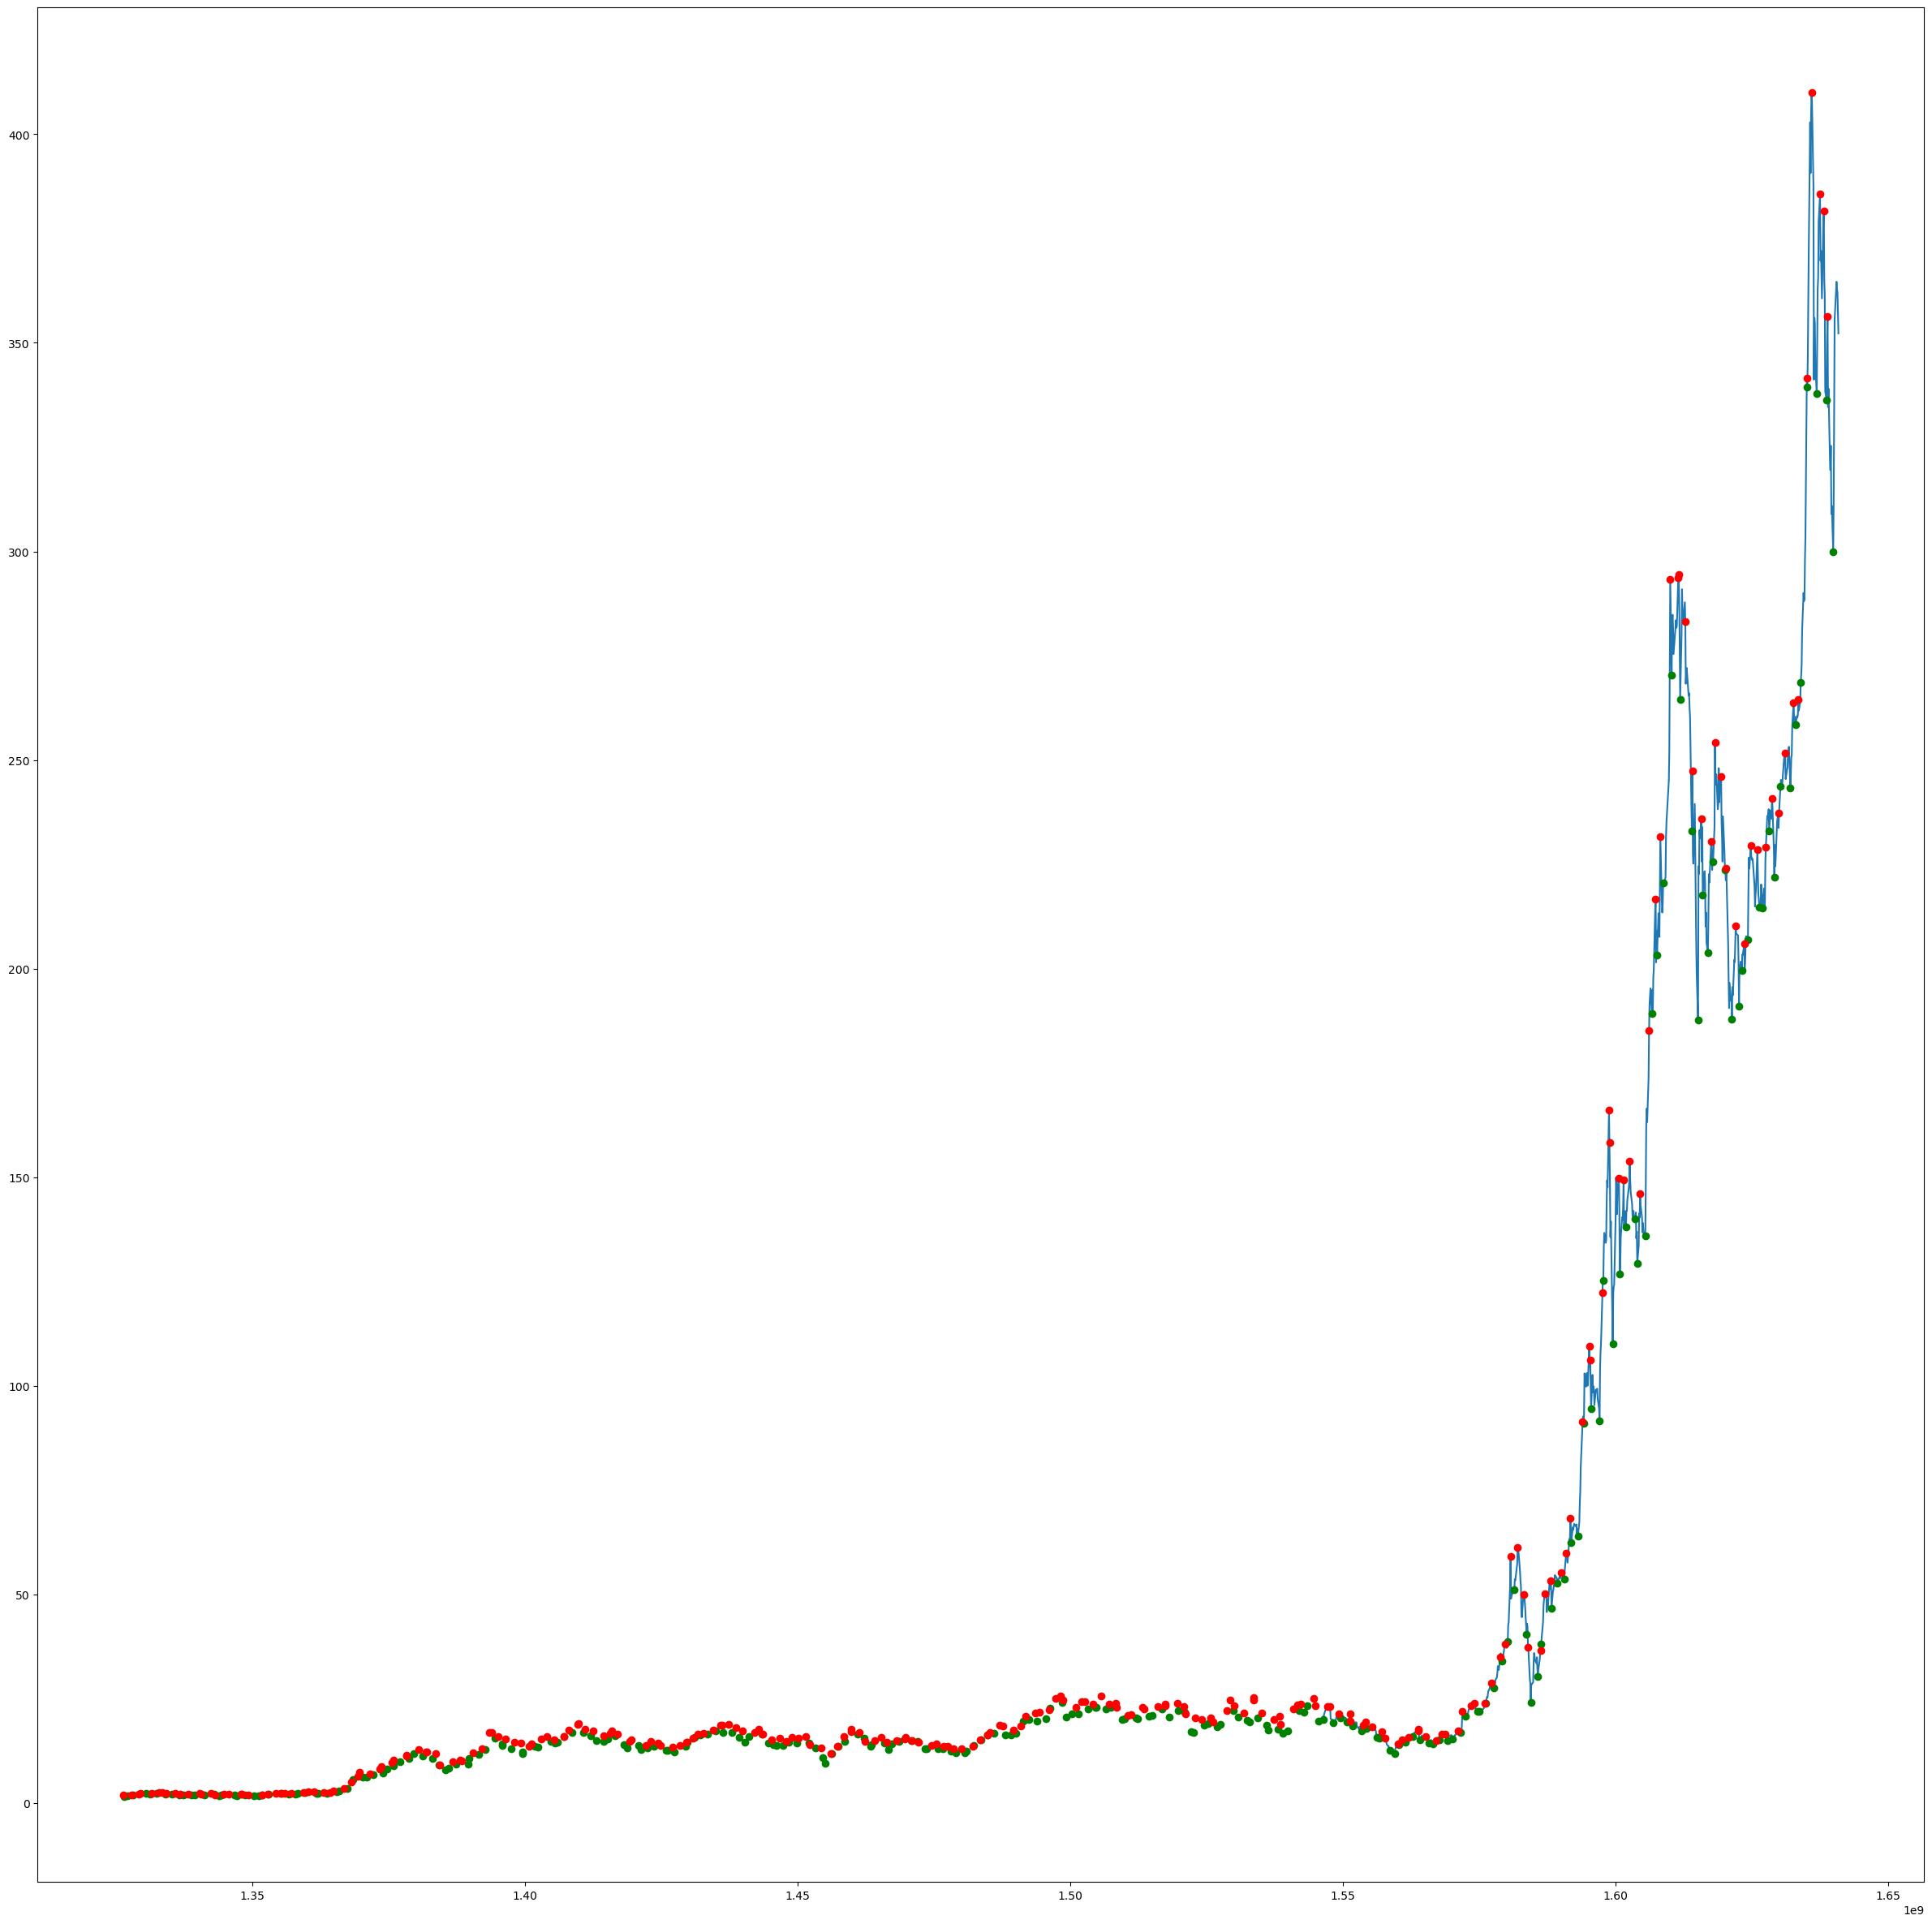

In [153]:
plt.figure(figsize=(30, 30))
plt.plot(stock_df["timestamps"], stock_df["Close"])
plt.plot(min_time, min_prices, 'o', color='g')
plt.plot(max_time, max_prices, 'o', color='r')

In [42]:
def min_max_matrix(df, interval):
    min_y = mins(df, int(1.5*interval))
    max_y = maxs(df, int(1.5*interval))
    dataframe = pd.DataFrame({})
    for i in range(len(df.columns)-interval):
        min_or_max=0
        col = list(range(interval+1))
        dict_={}
        row = np.array(df[df.columns[i:i+interval]])
        rowtime=df.columns[i:i+interval]
        row_list = row.tolist()[0]
        if to_timestamp(rowtime[len(rowtime)-1]) in min_y[0]:
            min_or_max=-1
        if to_timestamp(rowtime[len(rowtime)-1]) in max_y[0]:
            min_or_max=1
        row_list.append(min_or_max)
        for j in col:
            dict_[j] = row_list[j]
        dataframe=pd.concat([dataframe, pd.DataFrame([dict_])])
    return dataframe

In [43]:
matrix_df = min_max_matrix(horizontal_stock_df2(["TSLA"]),10)

In [44]:
matrix_df

,0,1,2,3,4,5,6,7,8,9,10
0,1.872000,1.847333,1.808000,1.794000,1.816667,1.841333,1.882000,1.883333,1.519333,1.773333,0
0,1.847333,1.808000,1.794000,1.816667,1.841333,1.882000,1.883333,1.519333,1.773333,1.787333,0
0,1.808000,1.794000,1.816667,1.841333,1.882000,1.883333,1.519333,1.773333,1.787333,1.784000,0
0,1.794000,1.816667,1.841333,1.882000,1.883333,1.519333,1.773333,1.787333,1.784000,1.773333,0
0,1.816667,1.841333,1.882000,1.883333,1.519333,1.773333,1.787333,1.784000,1.773333,1.784667,0
...,...,...,...,...,...,...,...,...,...,...,...
0,322.136658,319.503326,325.329987,308.973328,310.856659,299.980011,312.843323,336.290009,355.666656,364.646667,0
0,319.503326,325.329987,308.973328,310.856659,299.980011,312.843323,336.290009,355.666656,364.646667,362.823334,0
0,325.329987,308.973328,310.856659,299.980011,312.843323,336.290009,355.666656,364.646667,362.823334,362.063324,0
0,308.973328,310.856659,299.980011,312.843323,336.290009,355.666656,364.646667,362.823334,362.063324,356.779999,0


In [45]:
matrix_df.loc[matrix_df[10]==1]

,0,1,2,3,4,5,6,7,8,9,10
0,1.972000,2.016667,2.076667,2.120000,2.106667,2.128667,2.172000,2.073333,2.099333,2.211333,1
0,2.120000,2.106667,2.128667,2.172000,2.073333,2.099333,2.211333,2.240000,2.278667,2.331333,1
0,2.352667,2.333333,2.354667,2.332000,2.330667,2.343333,2.293333,2.272000,2.493333,2.529333,1
0,2.343333,2.293333,2.272000,2.493333,2.529333,2.523333,2.488667,2.482667,2.438667,2.534000,1
0,2.210667,2.210667,2.129333,2.121333,2.194000,2.232667,2.222667,2.208667,2.252000,2.262667,1
...,...,...,...,...,...,...,...,...,...,...,...
0,244.523331,250.973328,251.289993,251.619995,245.423340,247.666672,248.163330,251.943329,252.330002,253.163330,1
0,258.130005,263.786682,259.186676,260.436676,258.493347,258.406677,260.510010,260.196655,260.916656,264.536682,1
0,288.089996,288.600006,298.000000,303.226654,341.619995,339.476654,345.953339,359.013336,371.333344,402.863342,1
0,303.226654,341.619995,339.476654,345.953339,359.013336,371.333344,402.863342,390.666656,404.619995,409.970001,1


In [46]:
def stockmatrices():
    returner_df = pd.DataFrame({})
    for stock in nasdaq_df["Symbol"]:
        returner_df = pd.concat([returner_df, min_max_matrix(horizontal_stock_df2([stock]),10)])
    return returner_df

In [47]:
min_max_df = stockmatrices()

ARG: No data found for this date range, symbol may be delisted
Got error from yahoo api for ticker ALXN, Error: {'code': 'Not Found', 'description': 'No data found, symbol may be delisted'}
- ALXN: No timezone found, symbol may be delisted
Got error from yahoo api for ticker AGN, Error: {'code': 'Not Found', 'description': 'No data found, symbol may be delisted'}
- AGN: No timezone found, symbol may be delisted
Got error from yahoo api for ticker ABC, Error: {'code': 'Not Found', 'description': 'No data found, symbol may be delisted'}
- ABC: No timezone found, symbol may be delisted
Got error from yahoo api for ticker APC, Error: {'code': 'Not Found', 'description': 'No data found, symbol may be delisted'}
- APC: No timezone found, symbol may be delisted
APOL: No data found for this date range, symbol may be delisted
Got error from yahoo api for ticker AVP, Error: {'code': 'Not Found', 'description': 'No data found, symbol may be delisted'}
- AVP: No timezone found, symbol may be delis

Got error from yahoo api for ticker PKI, Error: {'code': 'Not Found', 'description': 'No data found, symbol may be delisted'}
- PKI: No timezone found, symbol may be delisted
PCLN: No data found for this date range, symbol may be delisted
Got error from yahoo api for ticker QEP, Error: {'code': 'Not Found', 'description': 'No data found, symbol may be delisted'}
- QEP: No timezone found, symbol may be delisted
Got error from yahoo api for ticker RTN, Error: {'code': 'Not Found', 'description': 'No data found, symbol may be delisted'}
- RTN: No timezone found, symbol may be delisted
Got error from yahoo api for ticker RHT, Error: {'code': 'Not Found', 'description': 'No data found, symbol may be delisted'}
- RHT: No timezone found, symbol may be delisted
RAI: No data found for this date range, symbol may be delisted
Got error from yahoo api for ticker RDC, Error: {'code': 'Not Found', 'description': 'No data found, symbol may be delisted'}
- RDC: No timezone found, symbol may be deliste

In [48]:
min_max_df =min_max_df.dropna()

In [156]:
min_max_df.loc[min_max_df[10]==1]

,0,1,2,3,4,5,6,7,8,9,10
0,58.803383,58.433662,58.789421,58.315105,58.754543,59.340466,59.849697,59.745090,59.717152,59.940372,1
0,60.484467,60.930885,60.986691,61.195972,61.077393,61.307568,61.363354,61.398266,60.784416,61.405243,1
0,60.784416,61.405243,61.377319,61.103443,61.552864,61.489689,61.517757,61.630131,61.728451,61.939114,1
0,61.461597,61.138538,59.656792,60.021988,60.892765,60.955982,61.475647,62.325375,62.409641,63.203190,1
0,62.746735,62.437725,62.198936,62.121727,62.585209,62.599247,62.114712,62.339413,62.648399,62.662472,1
...,...,...,...,...,...,...,...,...,...,...,...
0,52.704865,53.349850,52.677223,52.658794,52.631153,52.981289,52.059872,53.036572,52.870720,53.727634,1
0,51.018673,52.437660,54.695122,55.515175,57.947712,57.809494,58.730911,57.026295,58.647984,58.786194,1
0,57.533073,57.781853,57.256645,57.717358,57.256645,57.339573,58.279411,59.984032,59.495682,61.172665,1
0,60.610588,59.237694,59.716820,60.223602,60.381161,60.307014,61.066986,60.687008,61.493332,61.576736,1


In [50]:
X_min_max = min_max_df.drop(columns=[10])

In [51]:
y_min_max=min_max_df[10]

# Training Session Part II (Is it a max or min)?

In [52]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(X_min_max, y_min_max, random_state=0)

# Create scaler instance
X_scaler2 = skl.preprocessing.StandardScaler()

# Fit the scaler
X_scaler2.fit(X_train2)

# Scale the data
X_train_scaled2 = X_scaler2.transform(X_train2)
X_test_scaled2 = X_scaler2.transform(X_test2)

# Create the Keras Sequential model
John_Stockton_Model = tf.keras.models.Sequential()

# Add our first Dense layer, including the input layer
John_Stockton_Model.add(tf.keras.layers.Dense(units=5, activation="relu", input_dim=10))

# Add the output layer that uses a probability activation function
John_Stockton_Model.add(tf.keras.layers.Dense(units=5, activation="sigmoid",input_dim=10))

John_Stockton_Model.add(tf.keras.layers.Dense(units=1, activation="tanh",input_dim=10))

# Check the structure of the Sequential model
John_Stockton_Model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 5)                 55        
                                                                 
 dense_4 (Dense)             (None, 5)                 30        
                                                                 
 dense_5 (Dense)             (None, 1)                 6         
                                                                 
Total params: 91
Trainable params: 91
Non-trainable params: 0
_________________________________________________________________


In [53]:
X_train_scaled2

array([[-0.08009307, -0.08023168, -0.08013163, ..., -0.08034602,
        -0.08055814, -0.08065632],
       [-0.06673356, -0.06681055, -0.06676063, ..., -0.06684413,
        -0.06659208, -0.06677362],
       [-0.06248025, -0.06264965, -0.0628095 , ..., -0.06322706,
        -0.06338722, -0.06271106],
       ...,
       [-0.07517302, -0.0747611 , -0.07458889, ..., -0.07439425,
        -0.07424824, -0.07429289],
       [-0.06724663, -0.06744127, -0.06764714, ..., -0.06766878,
        -0.06750688, -0.06787899],
       [-0.07861333, -0.07855951, -0.07849297, ..., -0.07883777,
        -0.07889829, -0.07896499]])

In [54]:
# Compile the Sequential model together and customize metrics
John_Stockton_Model.compile(loss='mean_squared_error', optimizer="adam", metrics=["accuracy"])

In [55]:
# Fit the model to the training data
JS_fit_model = John_Stockton_Model.fit(X_train_scaled2, y_train2, epochs=20)

Epoch 1/20
21761/21761 [==============================] - 26s 1ms/step - loss: 0.1324 - accuracy: 0.8678
Epoch 2/20
21761/21761 [==============================] - 26s 1ms/step - loss: 0.1323 - accuracy: 0.8678
Epoch 3/20
21761/21761 [==============================] - 25s 1ms/step - loss: 0.1323 - accuracy: 0.8678
Epoch 4/20
21761/21761 [==============================] - 27s 1ms/step - loss: 0.1322 - accuracy: 0.8678
Epoch 5/20
21761/21761 [==============================] - 26s 1ms/step - loss: 0.1322 - accuracy: 0.8678
Epoch 6/20
21761/21761 [==============================] - 25s 1ms/step - loss: 0.1322 - accuracy: 0.8678
Epoch 7/20
21761/21761 [==============================] - 26s 1ms/step - loss: 0.1322 - accuracy: 0.8678
Epoch 8/20
21761/21761 [==============================] - 25s 1ms/step - loss: 0.1321 - accuracy: 0.8678
Epoch 9/20
21761/21761 [==============================] - 33s 2ms/step - loss: 0.1321 - accuracy: 0.8678
Epoch 10/20
21761/21761 [==============================

In [56]:
model_loss, model_accuracy = John_Stockton_Model.evaluate(X_test_scaled2,y_test2,verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

7254/7254 - 7s - loss: 0.1263 - accuracy: 0.8676 - 7s/epoch - 922us/step
Loss: 0.12633076310157776, Accuracy: 0.8676130175590515


In [57]:
not_sp_500_df = pd.read_csv("NotS&P.csv")

In [58]:
not_sp_500_df 

,Symbol,Description,IPO Date,Category2,Category3,GICS Sector,Market cap,Dividend yield,Country,Action
0,AAPL,Apple Inc,02/01/2001,Common stocks,Large cap,Information Technology,"$2,514,581,877,780",0.58%,USA,Analyze
1,MSFT,Microsoft Corp,02/26/2001,Common stocks,Large cap,Information Technology,"$2,066,846,488,973",0.93%,USA,Analyze
2,GOOG,Alphabet Inc Class C,08/19/2004,Common stocks,Large cap,Communication Services,"$1,263,113,280,000",0.00%,USA,Analyze
3,GOOGL,Alphabet Inc Class A,08/19/2004,Common stocks,Large cap,Communication Services,"$1,263,113,280,000",0.00%,USA,Analyze
4,AMZN,Amazon.Com Inc.,02/06/2001,Common stocks,Large cap,Consumer Discretionary,"$1,011,507,010,613",0.00%,USA,Analyze
...,...,...,...,...,...,...,...,...,...,...
195,CTVA,"Corteva, Inc.",05/24/2019,Common stocks,Large cap,Materials,"$40,483,113,967",1.03%,USA,Analyze
196,RSG,Republic Services Inc,03/06/2001,Common stocks,Large cap,Industrials,"$40,440,329,071",1.48%,USA,Analyze
197,IDXX,Idexx Laboratories Inc,02/20/2001,Common stocks,Large cap,Health Care,"$39,689,159,833",0.00%,USA,Analyze
198,STZ,Constellation Brands Class A,03/07/2001,Common stocks,Large cap,Consumer Staples,"$39,665,272,103",1.48%,USA,Analyze


In [60]:
start_date="2022-01-01"
end_date="2023-01-03"

In [61]:
def get_worthy_stocks():
    dict_ ={}
    stocks= []
    predictions =[]
    for stock in not_sp_500_df["Symbol"]:
        try:
            to_buy_or_not = nn_model1.predict(X_scaler.transform(horizontal_stock_df3(str(stock),"2012-01-01", "2022-01-01").drop(columns=["Ticker"])))
            stocks.append(stock)
            predictions.append(to_buy_or_not[0][0])
        except:
            pass
    dict_={"Ticker": stocks, "Predictions": predictions}
    return pd.DataFrame.from_dict(dict_)

In [62]:
sotcks = get_worthy_stocks()

1/1 [==============================] - 0s 18ms/step
Got error from yahoo api for ticker BRK.A, Error: {'code': 'Not Found', 'description': 'No data found, symbol may be delisted'}
- BRK.A: No timezone found, symbol may be delisted
Got error from yahoo api for ticker BRK.B, Error: {'code': 'Not Found', 'description': 'No data found, symbol may be delisted'}
- BRK.B: No timezone found, symbol may be delisted
1/1 [==============================] - 0s 19ms/step
Got error from yahoo api for ticker FB, Error: {'code': 'Not Found', 'description': 'No data found, symbol may be delisted'}
- FB: No timezone found, symbol may be delisted
1/1 [==============================] - 0s 22ms/step
Got error from yahoo api for ticker ANTM, Error: {'code': 'Not Found', 'description': 'No data found, symbol may be delisted'}
- ANTM: No timezone found, symbol may be delisted
1/1 [==============================] - 0s 21ms/step
FISV: No data found, symbol may be delisted
1/1 [==============================] - 0

In [135]:
test_stocks = list(sotcks.loc[sotcks["Predictions"]>.85345]["Ticker"])

In [136]:
len(test_stocks)

44

In [64]:
AON = horizontal_stock_df3("AON", start_date, end_date)

# Training done, now time to perform

In [65]:
def highs_and_lows(ticker, start_date, end_date):
    df = horizontal_stock_df3(ticker, start_date, end_date)
    min_time=[]
    max_time=[]
    min_price=[]
    max_price=[]
    min_pred_percent=[]
    max_pred_percent=[]
    min_dict={}
    max_dict={}
    for i in range(1, len(df.columns)-11):
        prices=df[df.columns[i:i+10]]
        dates = df.columns[i:i+10]
        if(John_Stockton_Model.predict(X_scaler2.transform(prices))[0][0]<-1*(0.0)):
            min_price.append(df[df.columns[i+9]][0])
            min_time.append(df.columns[i+9])
            min_pred_percent.append(John_Stockton_Model.predict(X_scaler2.transform(prices))[0][0])
        if(John_Stockton_Model.predict(X_scaler2.transform(prices))[0][0]>(0.00)):
            max_price.append(df[df.columns[i+9]][0])
            max_time.append(df.columns[i+9])
            max_pred_percent.append(John_Stockton_Model.predict(X_scaler2.transform(prices))[0][0])
    max_dict["Max Time"] = max_time
    max_dict["Max Price"] = max_price
    max_dict["Max Prediction Percent"] = max_pred_percent
    
    min_dict["Min Time"] = min_time
    min_dict["Min Price"] = min_price
    min_dict["Min Prediction Percent"] = min_pred_percent
            
                
    return (pd.DataFrame.from_dict(min_dict), pd.DataFrame.from_dict(max_dict))    
        
    

In [66]:
aon_low, aon_high=highs_and_lows("AON", start_date, end_date)

1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 20ms/step


In [67]:
aon_low

,Min Time,Min Price,Min Prediction Percent
0,1642147200,269.368683,-0.209170
1,1642492800,268.610168,-0.221093
2,1642579200,266.590790,-0.240965
3,1642665600,266.216461,-0.222007
4,1642752000,262.443604,-0.225647
...,...,...,...
115,1671609600,300.755890,-0.079801
116,1671696000,297.897461,-0.082901
117,1671782400,298.334167,-0.066174
118,1672128000,298.711304,-0.040191


In [68]:
aon_high

,Max Time,Max Price,Max Prediction Percent
0,1643616000,272.829102,0.043192
1,1643702400,273.194183,0.082540
2,1643788800,274.990479,0.108705
3,1643875200,272.888275,0.083139
4,1643961600,287.504822,0.205034
...,...,...,...
115,1669881600,300.795593,0.006568
116,1669968000,304.477722,0.021015
117,1670227200,306.423035,0.031135
118,1670313600,305.648895,0.033562


In [69]:
AON_T = AON.T.reset_index().drop(0)
AON_T

,index,0
1,1641196800,288.863281
2,1641283200,289.87793
3,1641369600,288.626892
4,1641456000,286.164246
5,1641542400,278.559418
...,...,...
247,1671782400,298.334167
248,1672128000,298.711334
249,1672214400,297.262299
250,1672300800,301.103271


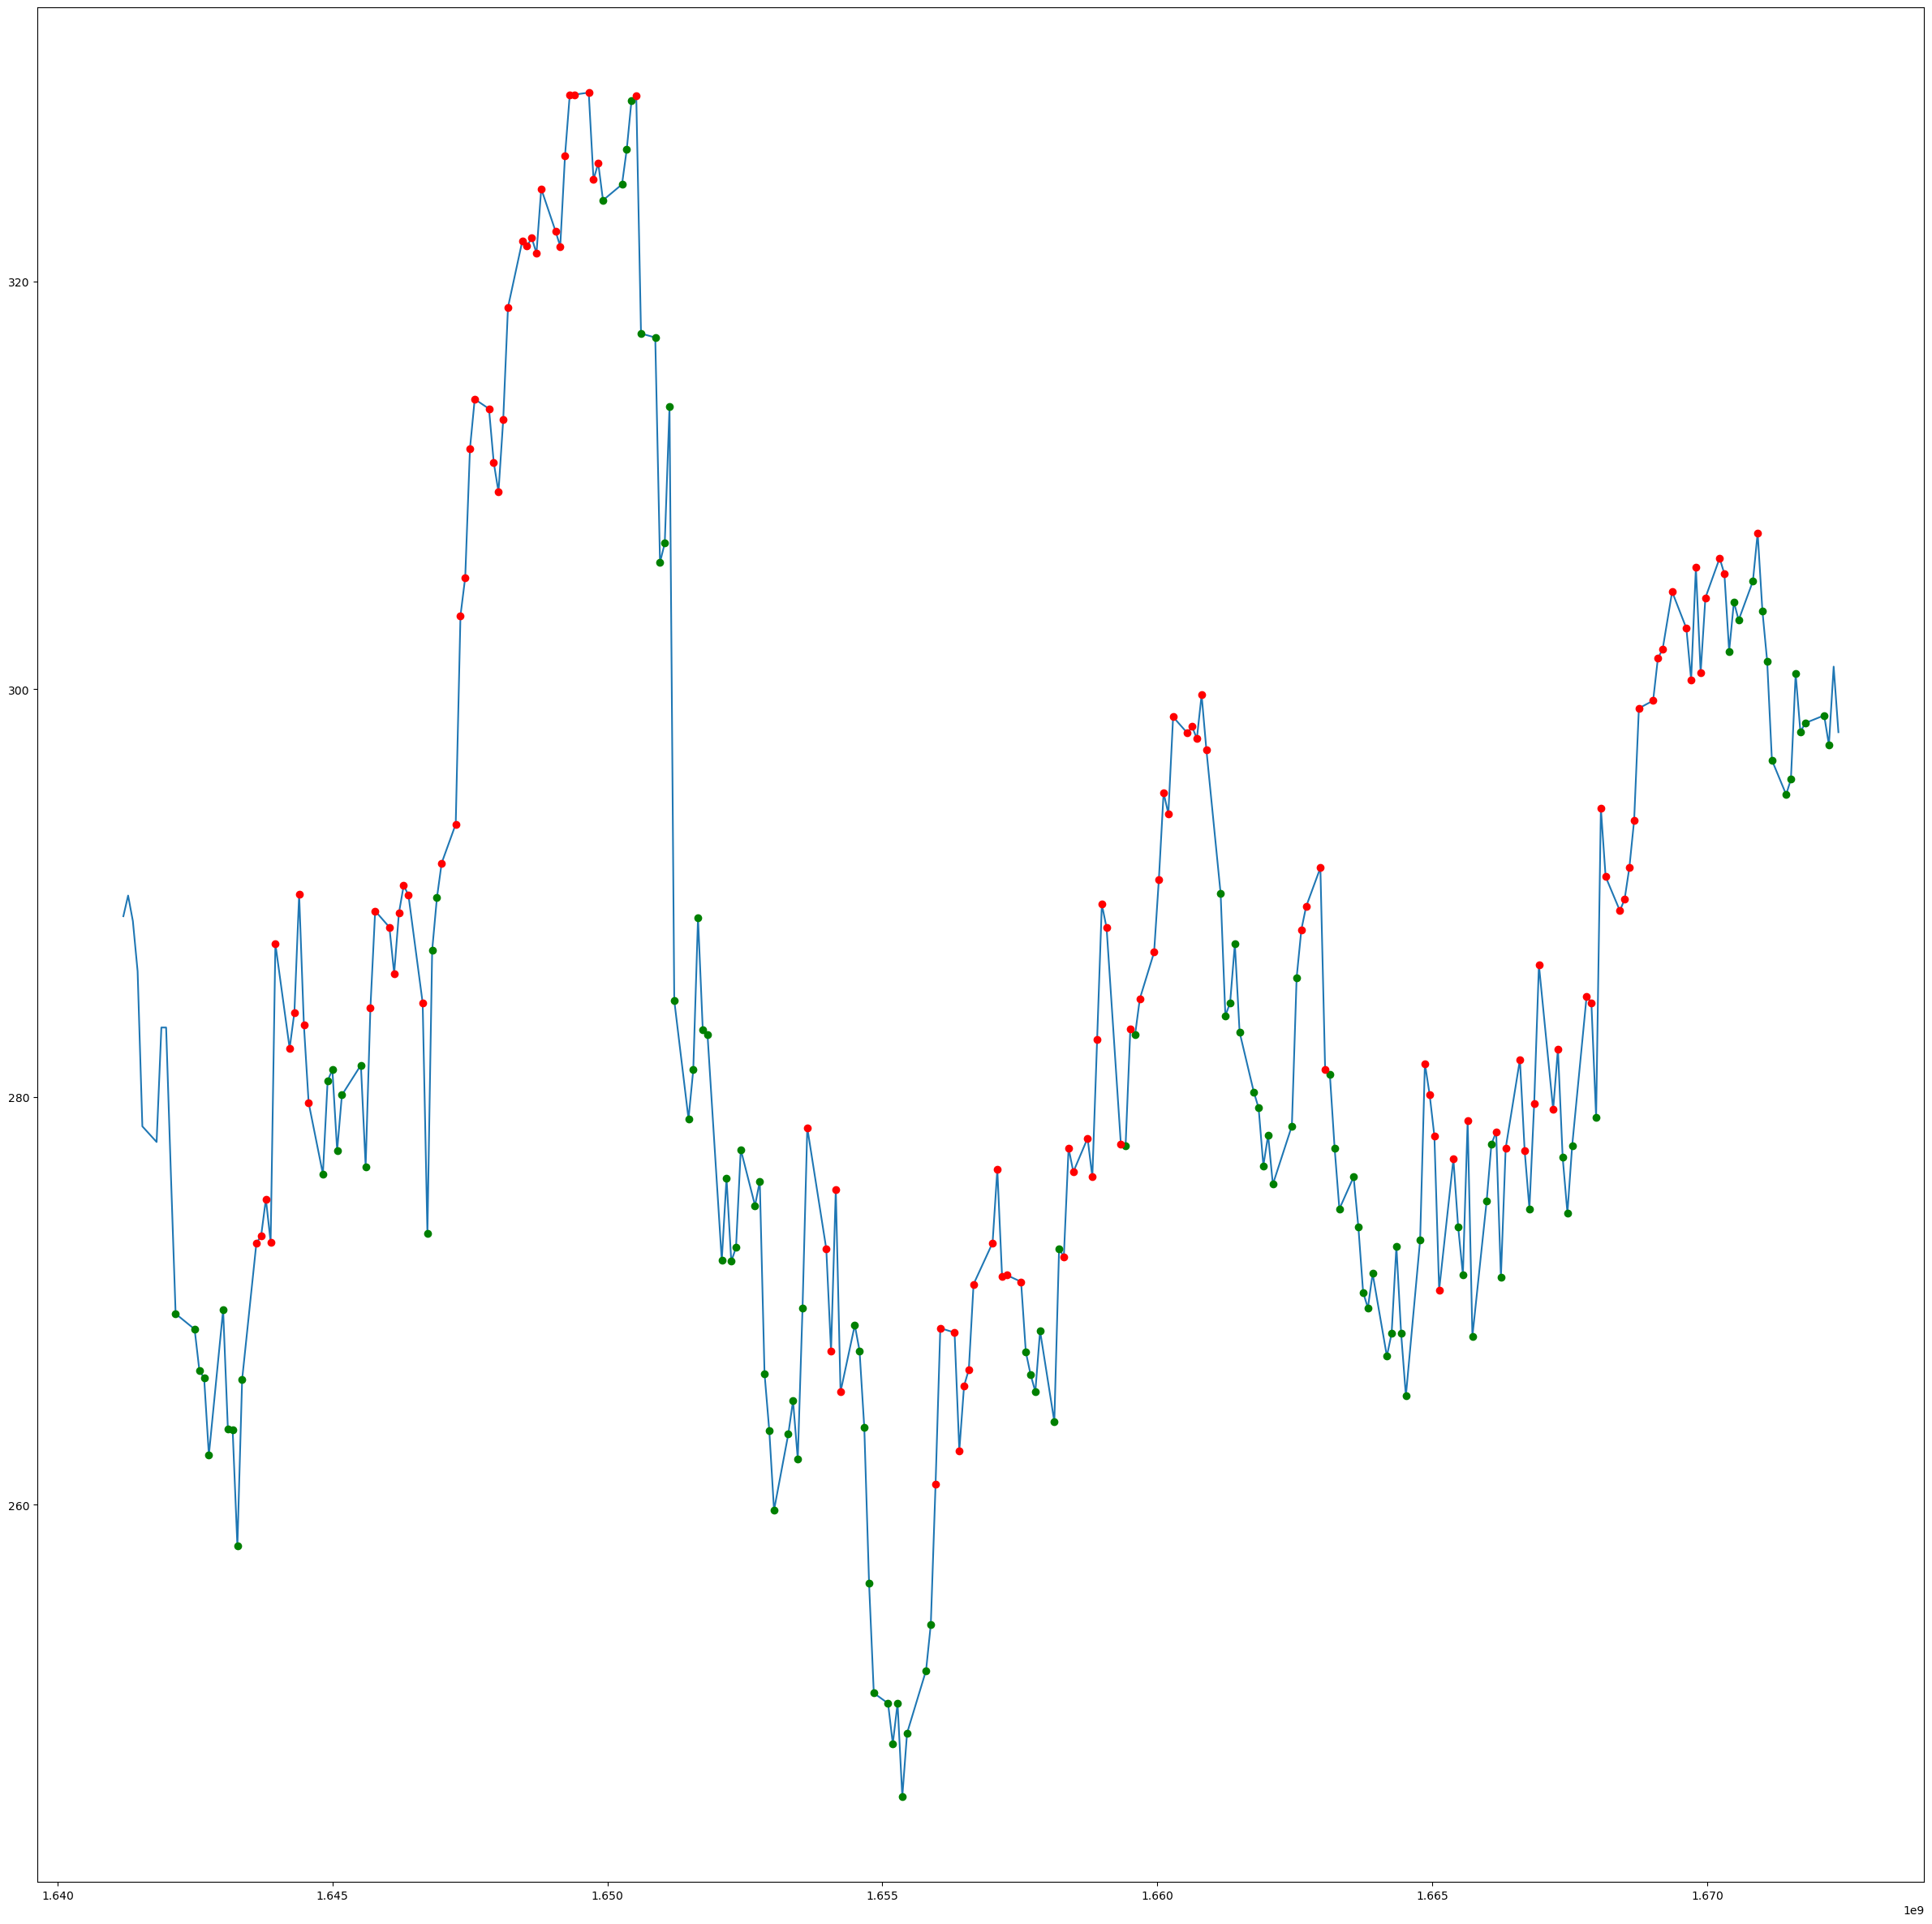

In [70]:
plt.figure(figsize=(30, 30))
plt.plot(AON_T["index"], AON_T[0])
plt.plot(aon_low['Min Time'], aon_low["Min Price"], 'o', color="g")
plt.plot(aon_high['Max Time'], aon_high["Max Price"], 'o', color="r")
plt.show()

In [71]:
def graph_extrema(ticker):
    low, high=highs_and_lows(ticker, start_date, end_date)
    data = horizontal_stock_df3(ticker, start_date, end_date).T.reset_index().drop(0)
    plt.figure(figsize=(30, 30))
    plt.plot(data["index"], data[0])
    plt.plot(low['Min Time'], low["Min Price"], 'o', color="g")
    plt.plot(high['Max Time'], high["Max Price"], 'o', color="r")
    plt.show()
    
    return low, high

1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 19ms/step


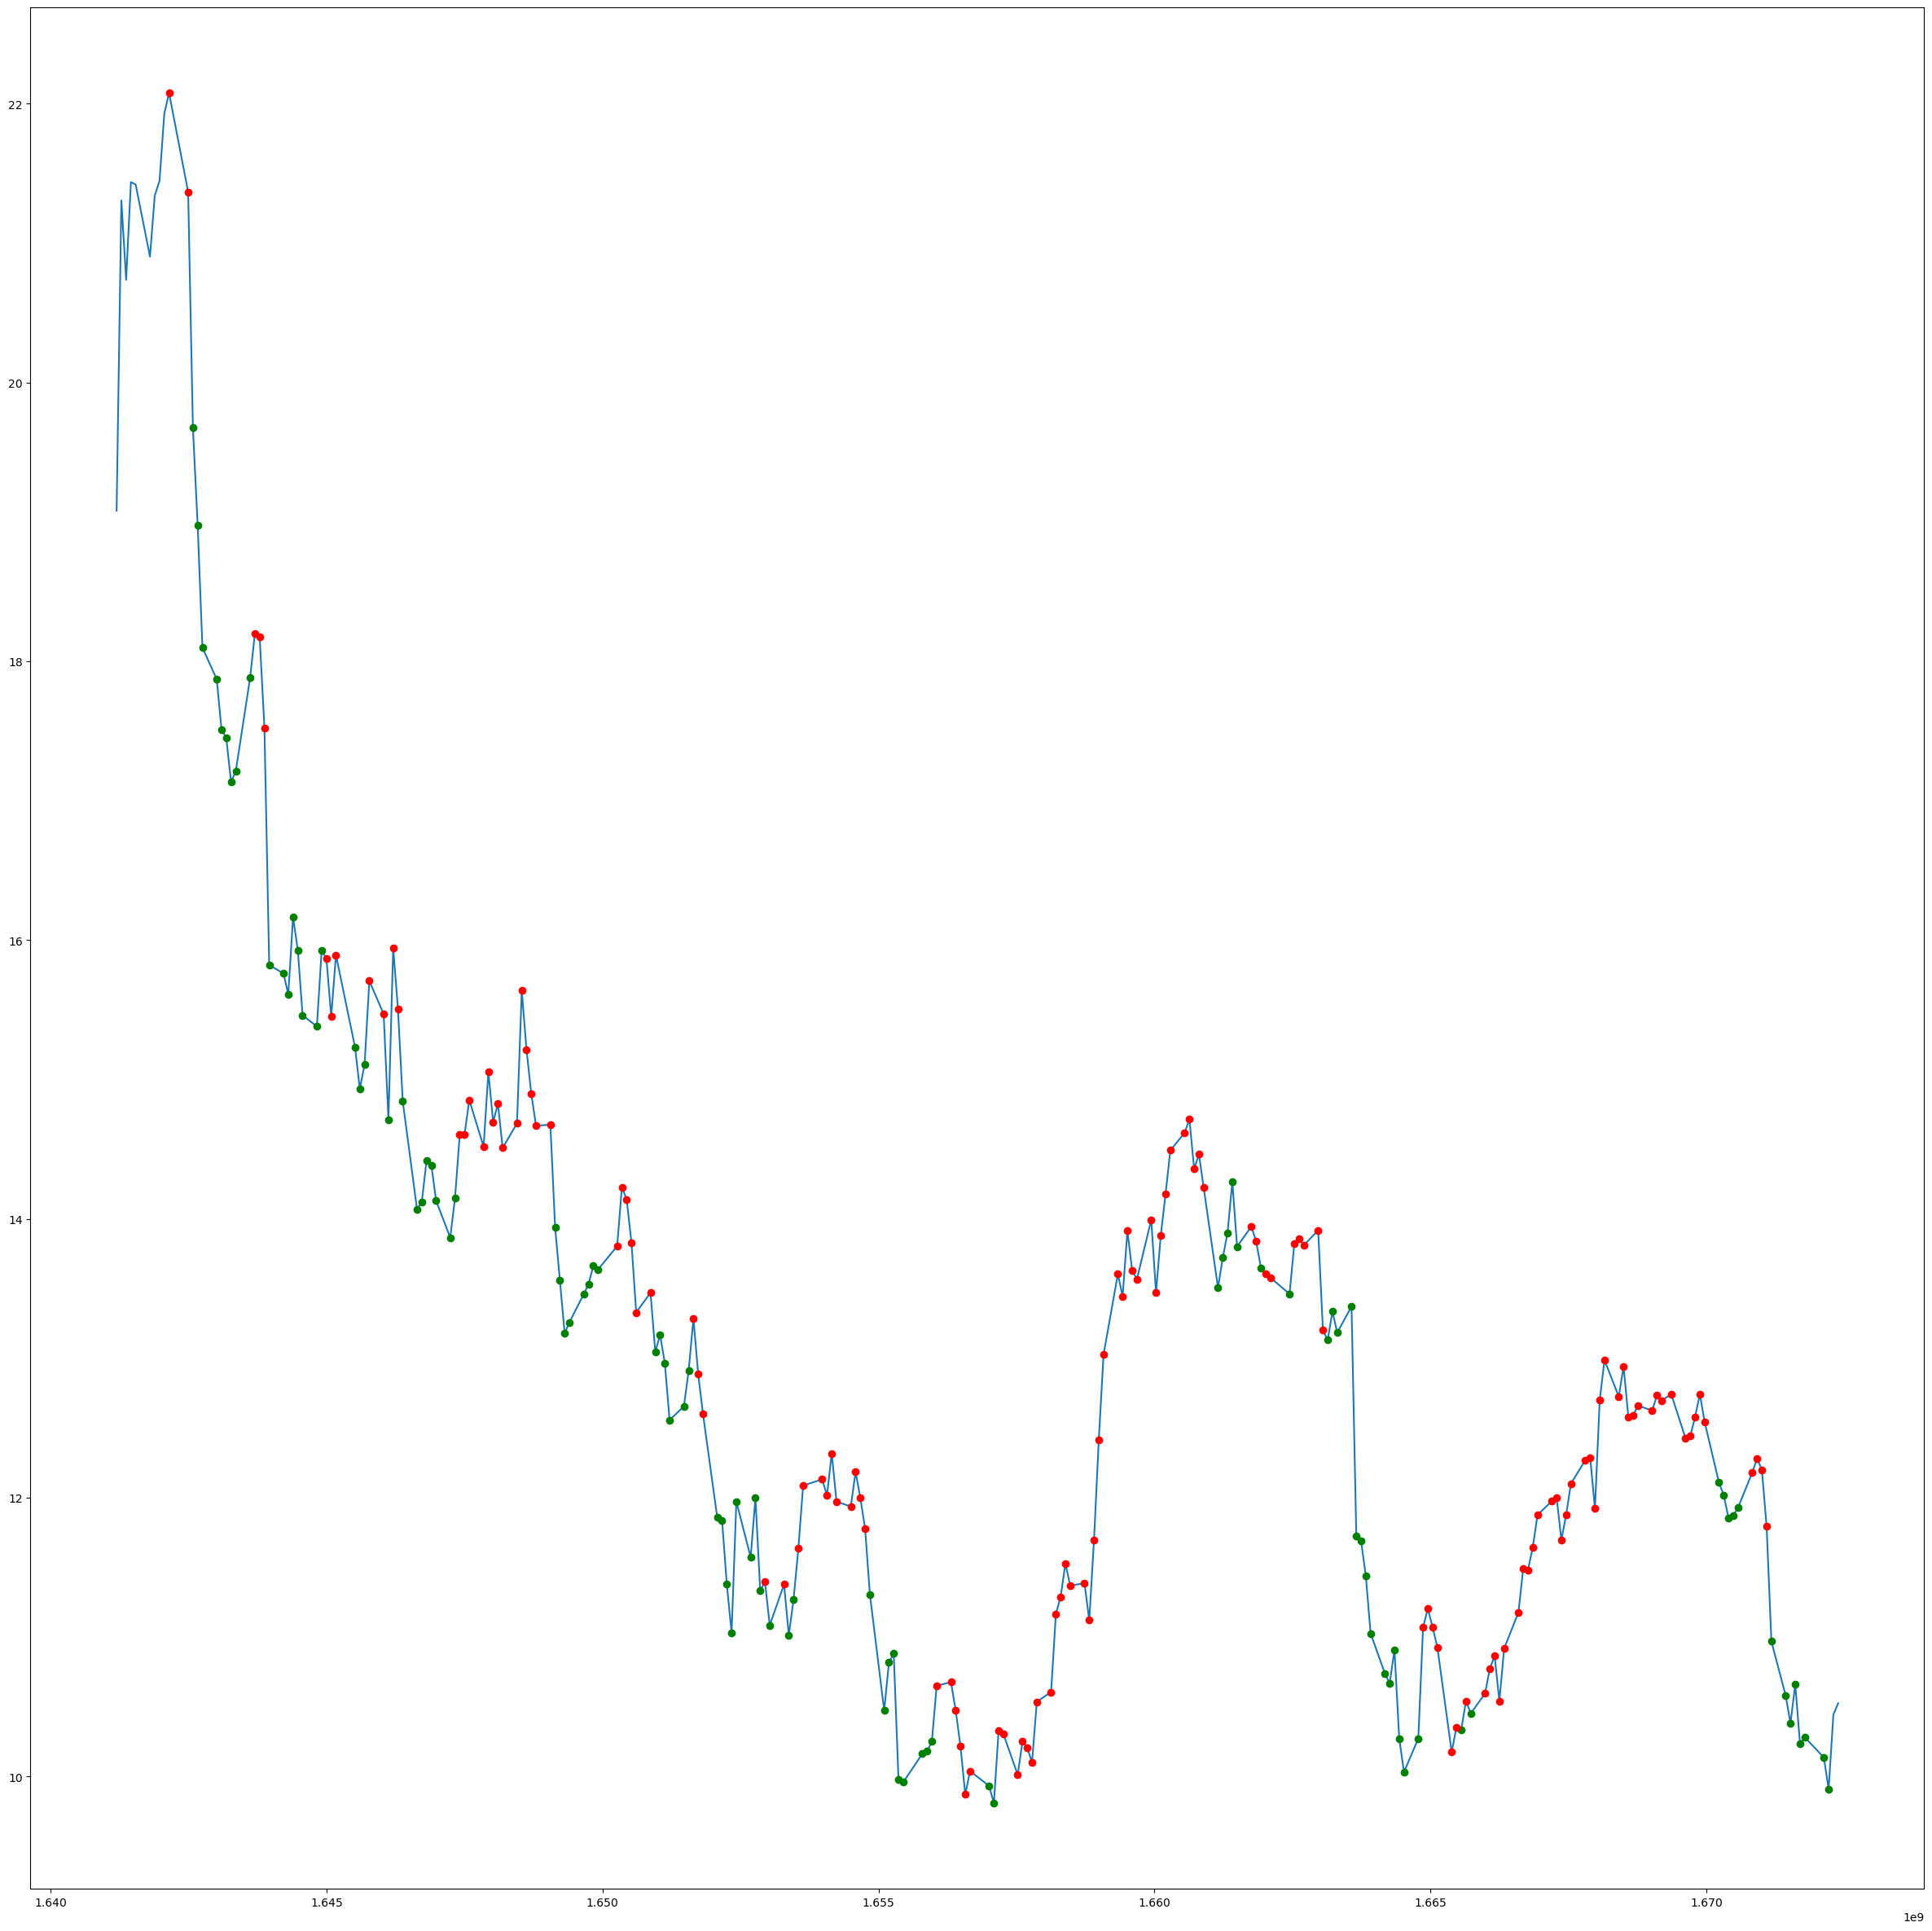

(       Min Time  Min Price  Min Prediction Percent
 0    1642579200  19.675282               -0.018164
 1    1642665600  18.974157               -0.040525
 2    1642752000  18.097752               -0.059702
 3    1643011200  17.869886               -0.068378
 4    1643097600  17.510561               -0.073524
 ..          ...        ...                     ...
 96   1671609600  10.660633               -0.024082
 97   1671696000  10.235294               -0.028570
 98   1671782400  10.280542               -0.023709
 99   1672128000  10.135746               -0.020915
 100  1672214400   9.909502               -0.018330
 
 [101 rows x 3 columns],
        Max Time  Max Price  Max Prediction Percent
 0    1642147200  22.076628                0.027766
 1    1642492800  21.366741                0.014894
 2    1643702400  18.199610                0.000595
 3    1643788800  18.173180                0.012460
 4    1643875200  17.521307                0.007664
 ..          ...        ...          

In [73]:
graph_extrema("F")

In [75]:
def buy_sell(ticker, budget):
    low, high=highs_and_lows(ticker, start_date, end_date)
    dictionary = {}
    return_dict={}
    og_budget = budget
    shares=0
    price=0
    for i in range(len(high["Max Time"])):
        dictionary[high["Max Time"][i]] = [high["Max Prediction Percent"][i], high["Max Price"][i]]
    for i in range(len(low["Min Time"])):
        dictionary[low["Min Time"][i]] = [low["Min Prediction Percent"][i], low['Min Price'][i]]
    dictionary = dict(sorted(dictionary.items()))
    
    
    for key in dictionary.items():
        price =key[1][1]
        prediction = key[1][0]
        #buy
        if prediction<0:
            shares = shares+(budget*-1*prediction)/price
            budget=budget*(1+prediction)
        #sell
        if (prediction>0 and shares>0):
            budget = budget+(shares*prediction)*price
            shares= shares*(1-prediction)
    return_dict["Ticker"]=ticker
    return_dict["Starting Budget"] = og_budget
    return_dict["Shares"] = shares
    return_dict["Amount Accrued"] = budget+shares*price
    
    return return_dict
    

In [76]:
 buy_sell("AON", 1000)

1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 19ms/step


{'Ticker': 'AON',
 'Starting Budget': 1000,
 'Shares': 2.2366652979986874,
 'Amount Accrued': 1088.2647856767467}

In [77]:
def buy_hold(ticker, budget):
    stock_data = horizontal_stock_df3(ticker, start_date, end_date).T.reset_index().drop(0)
    initial_shares = budget/list(stock_data[0])[0]
    final_amount = initial_shares*(list(stock_data[0])[len(stock_data)-1])
    return final_amount

In [78]:
 buy_hold("AON", 1000)

1031.240699751613

In [79]:
 buy_hold("F", 1000)

551.6382383714107

In [80]:
 buy_sell("F", 1000)

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 21ms/step


{'Ticker': 'F',
 'Starting Budget': 1000,
 'Shares': 31.748433923518853,
 'Amount Accrued': 843.7474937815477}

In [81]:
def buy_sell_vs_hold(tickers, budget):
    comparison_df = pd.DataFrame({})
    for ticker in tickers:
        data_dict= buy_sell(ticker, budget)
        data_dict["Buy and Hold Total"] = buy_hold(ticker, budget)
        comparison_df= pd.concat([comparison_df, pd.DataFrame([data_dict])])
    return comparison_df

In [137]:
comparison_df = buy_sell_vs_hold(test_stocks, 10000)

1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 34ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 19ms/step


In [160]:
comparison_df=comparison_df.rename(columns={"Amount Accrued": "John Stockton"})
comparison_df

,Ticker,Starting Budget,Shares,John Stockton,Buy and Hold Total
0,UNH,10000,8.897168,11408.608547,10690.647635
0,MA,10000,19.531955,10987.599464,9428.961398
0,HD,10000,19.637088,9949.353504,7924.005244
0,AVGO,10000,1.031541,10876.184678,8700.360938
0,COST,10000,19.450328,9451.938741,8109.159434
0,TMO,10000,9.958692,11513.028783,8557.758753
0,ACN,10000,36.017917,9625.925019,6642.282236
0,ADBE,10000,13.178879,9712.339598,5962.932149
0,NFLX,10000,27.317445,8311.347991,4936.304255
0,AMGN,10000,40.687629,11214.609564,11951.812765


<AxesSubplot:>

<Figure size 3000x3000 with 0 Axes>

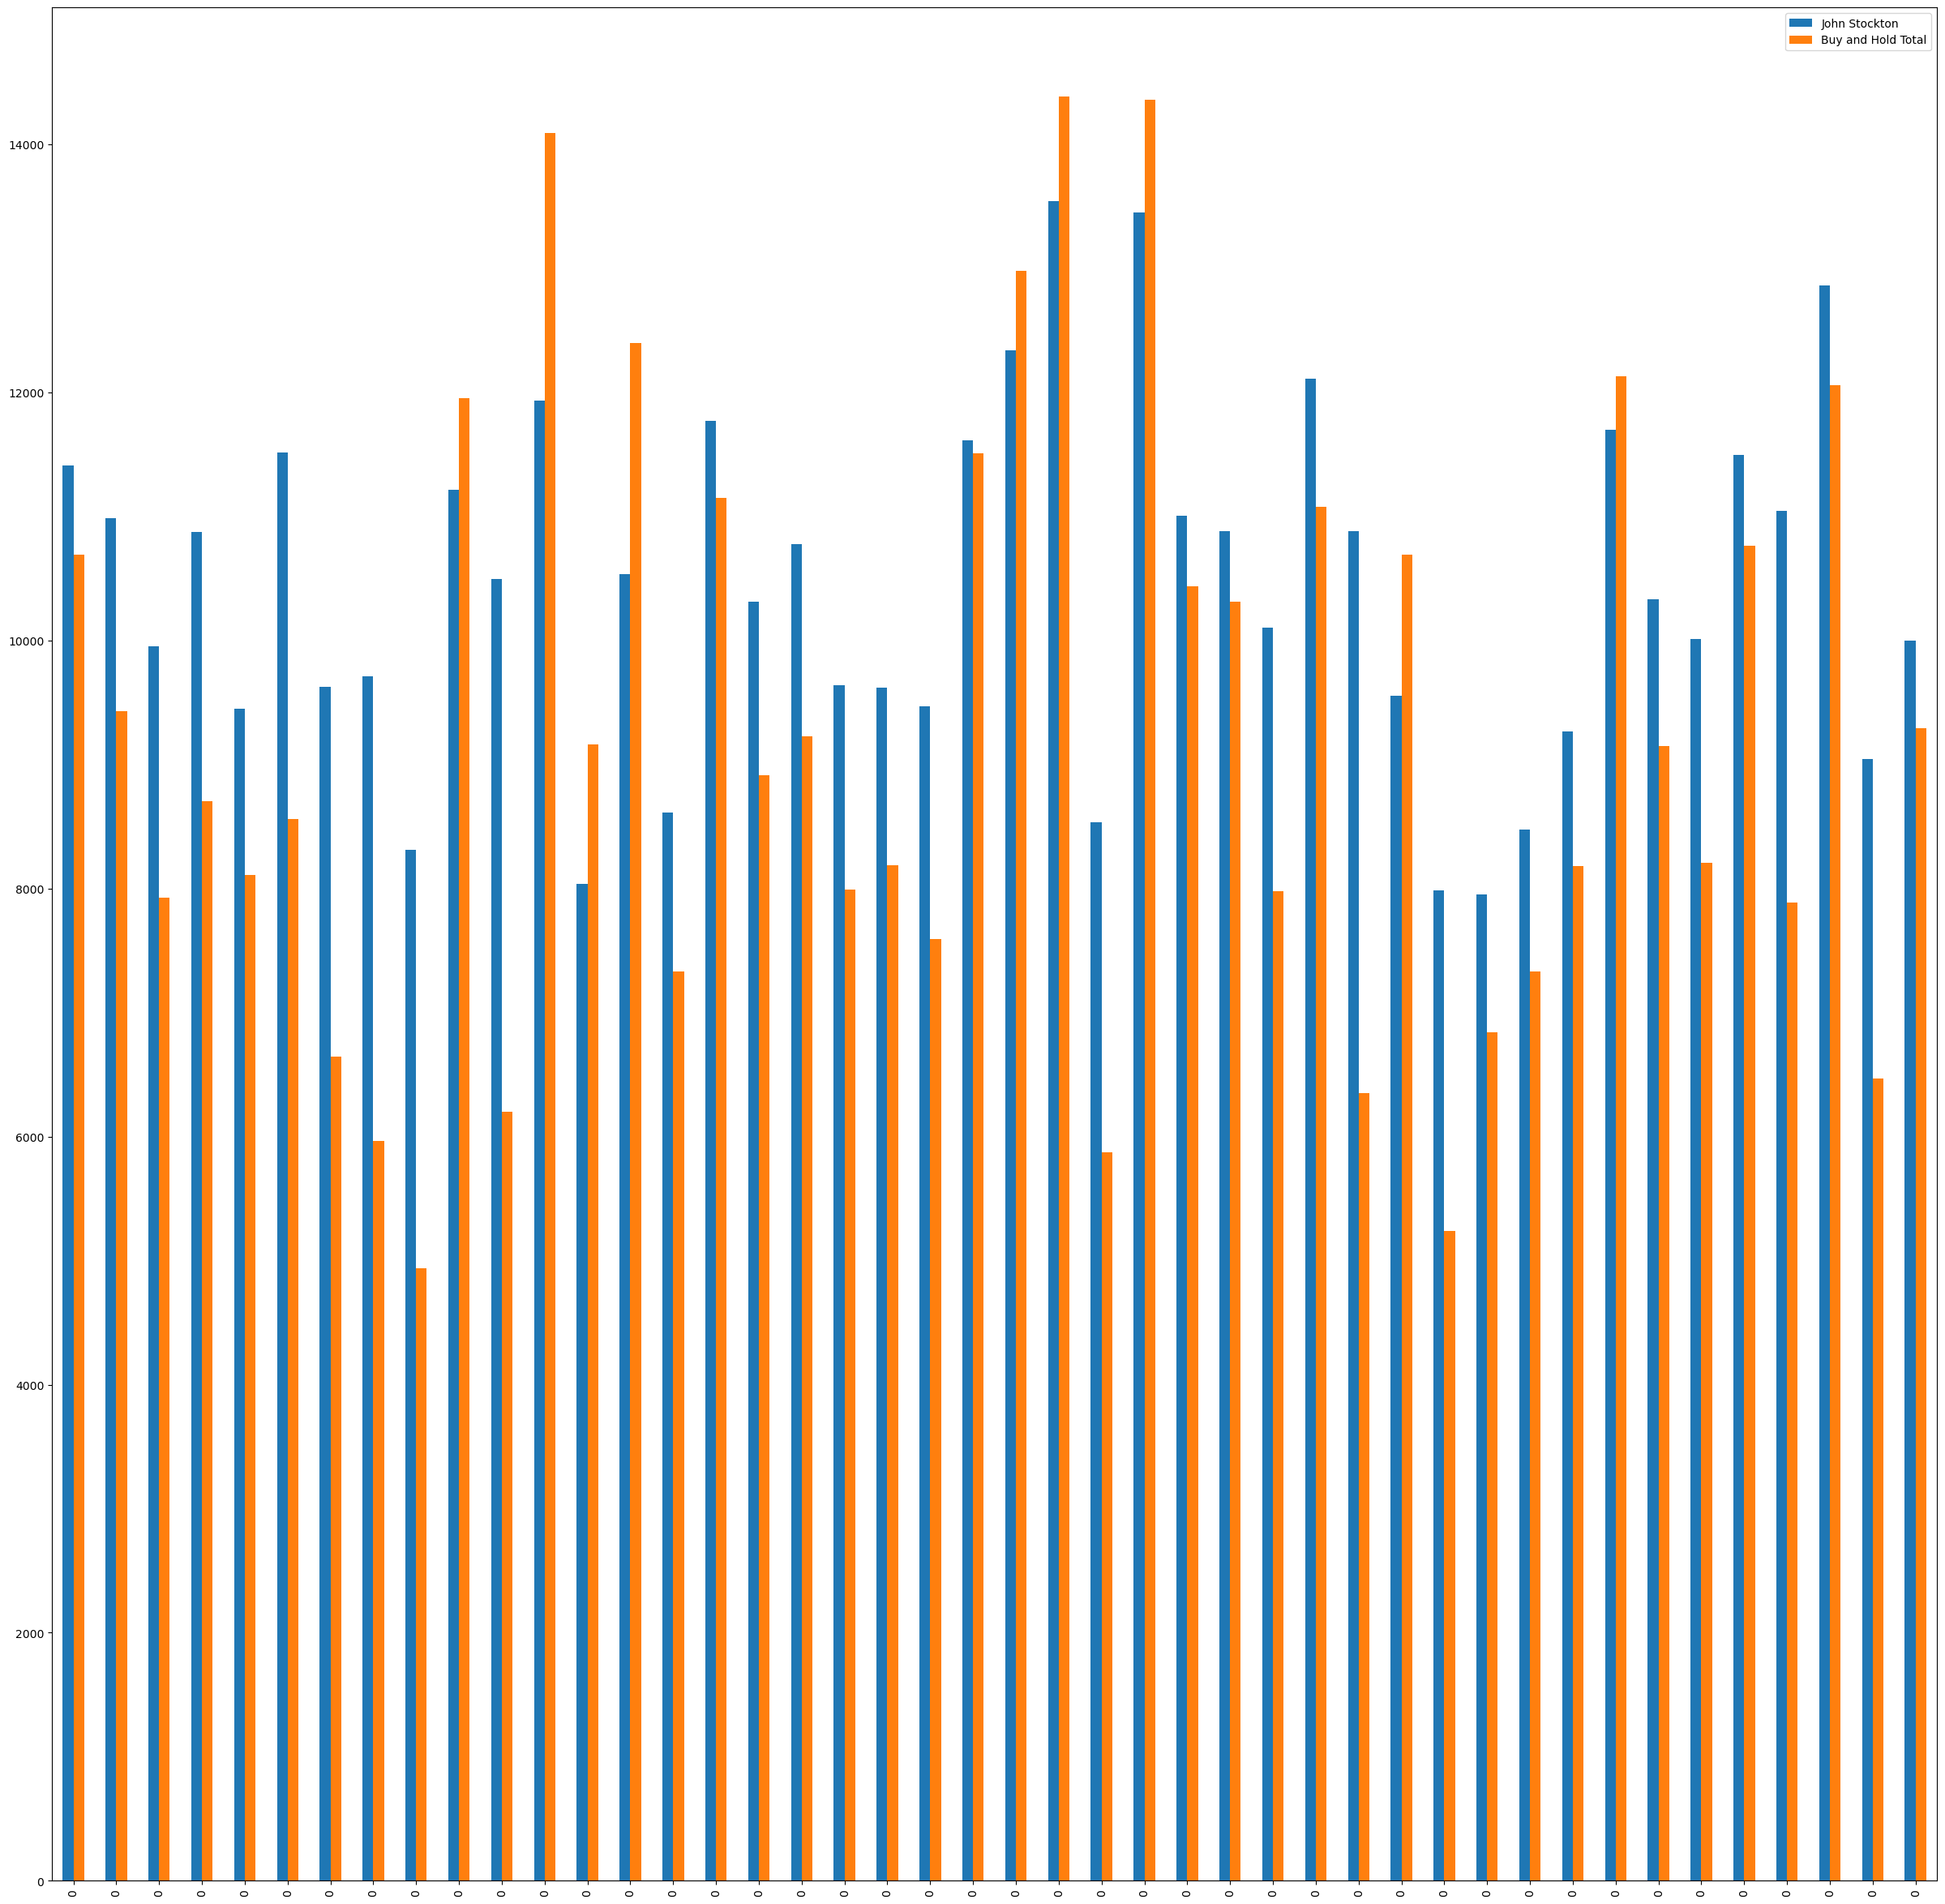

In [161]:
plt.figure(figsize=(30, 30))
comparison_df[["John Stockton","Buy and Hold Total"]].plot.bar(rot=90,figsize=(30, 30))

In [162]:
comparison_df.agg('sum')

Ticker                UNHMAHDAVGOCOSTTMOACNADBENFLXAMGNINTULMTBADESP...
Starting Budget                                                  440000
Shares                                                         722.8546
John Stockton                                             458414.698742
Buy and Hold Total                                        404624.504938
dtype: object

In [163]:
stats.ttest_ind(comparison_df["John Stockton"], comparison_df["Buy and Hold Total"])

Ttest_indResult(statistic=2.852542566945497, pvalue=0.005431066370539627)

In [164]:
nn_model1.save("nn_model1.h5")

In [165]:
John_Stockton_Model.save("John_Stockton_Model.h5")